# 1. Setup

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
import json
import logging
import os
from datetime import datetime
from pathlib import Path

import pandas as pd
import regex as re
import typer
from dateutils import relativedelta
from unidecode import unidecode

from analysis.config import *
from analysis.preprocessing import map_progress, tokenizer_lemma
from analysis.utils import *
from src.custom_logger import get_logger

# Removendo aviso de debug
os.environ["PYDEVD_WARN_SLOW_RESOLVE_TIMEOUT"] = "3000"
# Removendo limitação de print de dfs
# pd.set_option("display.max_rows", 500)
# pd.set_option("display.max_columns", 500)
# pd.set_option("display.width", 1000)

# Caminho da pasta contendo os csvs
data_path = "data/2023/01/19/"
places_file = "data/places.csv"
input_file = "input/hotels_23_01_19.csv"
reports_folder = Path("./reports")
Path(reports_folder).mkdir(exist_ok=True)
data_folder = Path("./data/prep")
Path(data_folder).mkdir(exist_ok=True)


In [3]:
from tqdm import tqdm
tqdm.pandas()

In [4]:
from itertools import chain

join_str = lambda x: "\n".join(list(x)) if x is not None else ""
join_list = lambda x: list(chain.from_iterable(x))

# 2. Stats

```
Hotéis         50
Avaliações 150774
Sentenças  329235
Tokens    1633318
```

In [6]:
df_prep = pd.read_parquet("data/prep/df_text_prep_2023-06-22_20-52-11_175568.pq")
df_hotels = pd.read_parquet("data/prep/df_hotels_2023-06-22_20-52-11_175568.pq")

In [22]:
n_hotels = df_prep.name.drop_duplicates().count()
n_hotels

50

In [16]:
df_prep["text_na"] = (df_prep.text == '') | (df_prep.text.isna())

In [23]:
n_reviews = (~df_prep["text_na"]).sum()
n_reviews

150774

In [31]:
n_sentences = df_prep[(~df_prep["text_na"])].text_tokens.apply(len).sum()
n_sentences

329235

In [28]:
n_tokens = df_prep.text_tokens.apply(join_list).apply(len).sum()
n_tokens

1633318

# 3. Corpus

In [151]:
import numpy as np

# Review level documents
text_tokens_flat = df_prep[(~df_prep["text_na"])].text_tokens.apply(join_list)
df_prep.loc[(~df_prep["text_na"]),"text_tokens_flat"] = text_tokens_flat

# Hotel level documents
# text_tokens_flat = df_hotels.text_tokens_sum.apply(join_list)

text_tokens_flat.shape

(150774,)

In [34]:
text_tokens_flat.head()

0    [bom, preco, otima, localizacao, atendimento, ...
1    [nunca, quarto, hotel, tao, sujo, vida, lencol...
2    [hotel, baixissima, qualidad, atendimento, aco...
3    [pessimo, atendimento, classico, rio, janeiro,...
6    [experiencia, nao, boa, ness, hotel, propagand...
Name: text_tokens, dtype: object

In [35]:
from gensim import corpora

corpus = text_tokens_flat.to_list()
gensim_dictionary = corpora.Dictionary(corpus)

text_tokens_corpus = text_tokens_flat.progress_apply(lambda x:gensim_dictionary.doc2bow(x, allow_update=False))
gensim_corpus = text_tokens_corpus.to_list()

100%|██████████| 150774/150774 [00:01<00:00, 107786.02it/s]


# 4. Topic Modeling

In [36]:
# Treinando modelo
import gensim
from gensim.models import CoherenceModel

hdp_model = gensim.models.hdpmodel.HdpModel(
    corpus=gensim_corpus, 
    id2word=gensim_dictionary, 
    T=30
)

In [38]:
lda_model = gensim.models.ldamodel.LdaModel(
    corpus=gensim_corpus, 
    num_topics=10, 
    id2word=gensim_dictionary, 
    passes=10,
    # per_word_topics=True
)

In [39]:
def perplexity_score(model: gensim.models.ldamodel.LdaModel):
    return model.log_perplexity(gensim_corpus)

print('LDA Perplexity:', perplexity_score(lda_model))

LDA Perplexity: -7.826251888663526


In [40]:
def coherence_score(model, coherence='u_mass'):
    coherence_score_model = CoherenceModel(model=model, texts=corpus, dictionary=gensim_dictionary, coherence=coherence)
    return coherence_score_model.get_coherence()

print("u_mass")
print('LDA Coherence Score:', coherence_score(lda_model))
print('HDP Coherence Score:', coherence_score(hdp_model))

u_mass
LDA Coherence Score: -3.4015809945855375
HDP Coherence Score: -2.119564010808948


In [ ]:
# inspect the size of a python object in bytes
import joblib
joblib.dump(lda_model, "lda_model.joblib")
# 6mb

['lda_model.joblib']

In [50]:
def train_and_eval(n, alpha, beta):
    lda_model = gensim.models.ldamodel.LdaModel(
        corpus=gensim_corpus, 
        id2word=gensim_dictionary, 
        passes=4,
        # chunksize=100,
        # per_word_topics=True,
        num_topics=n, 
        alpha=alpha,
        eta=beta,
    )
    p = perplexity_score(lda_model)
    c = coherence_score(lda_model)
    return lda_model, {"n":n, "alpha":alpha, "beta":beta, "perplexity":p, "coherence":c}

In [52]:
import itertools
import pyperclip
import random
#list containing various hyperparameters
grid = {
    # "n":[4,6,8,10,12,14,16,18,20],
    "n":[6,10,14,18,20],
    "alpha":['symmetric',0.3,0.5,0.7],
    "beta":['auto',0.3,0.5,0.7],
}


combinations_list = list(itertools.product(*grid.values()))
random.shuffle(combinations_list)
l = len(combinations_list)
print("len(combinations_list)", l)

# EARLY_STOP_CLIPBOARD_STRING

results = []
best_result = None
best_model = None
for i, params in tqdm(enumerate(combinations_list), total=l):
    model, result = train_and_eval(*params)
    results.append(result)
    if best_result is None or results[-1]["coherence"] > best_result["coherence"]:
        best_result = results[-1]
        best_model = model
        print("best_result", results[-1])
    try:
        if pyperclip.paste() == "STOP_CLIPBOARD_STRING":
            print("Early stop via clipboard!")
            break
    except:
        pass

joblib.dump(results, "results/results.joblib")
joblib.dump(best_model, "results/best_model.joblib")

len(combinations_list) 80


  1%|▏         | 1/80 [03:03<4:01:39, 183.54s/it]

best_result {'n': 18, 'alpha': 'symmetric', 'beta': 0.7, 'perplexity': -7.595399235113707, 'coherence': -8.311762498090873}


  2%|▎         | 2/80 [05:45<3:42:00, 170.77s/it]

best_result {'n': 18, 'alpha': 0.5, 'beta': 0.7, 'perplexity': -7.685513670969638, 'coherence': -4.490476717559394}
best_result {'n': 10, 'alpha': 0.5, 'beta': 0.5, 'perplexity': -7.4341848545209315, 'coherence': -3.584082484948334}


  4%|▍         | 3/80 [08:10<3:24:11, 159.11s/it]

best_result {'n': 6, 'alpha': 0.5, 'beta': 0.7, 'perplexity': -7.36331949969407, 'coherence': -2.723083288705507}


 15%|█▌        | 12/80 [28:34<2:34:51, 136.65s/it]

best_result {'n': 6, 'alpha': 'symmetric', 'beta': 'auto', 'perplexity': -7.384623810052592, 'coherence': -2.7058403031678058}


 89%|████████▉ | 71/80 [2:44:13<20:48, 138.69s/it]  

best_result {'n': 6, 'alpha': 0.3, 'beta': 0.5, 'perplexity': -7.326465169620303, 'coherence': -2.7023035454711146}


100%|██████████| 80/80 [3:05:31<00:00, 139.14s/it]


NameError: name 'joblib' is not defined

In [53]:
import joblib

joblib.dump(results, "results/results.joblib")
joblib.dump(best_model, "results/best_model.joblib")

['results/best_model.joblib']

# 5. Results

In [55]:
df_gs = pd.DataFrame(results)
df_gs.describe()

,n,perplexity,coherence
count,80.000000,80.000000,80.000000
mean,13.600000,-7.950574,-4.218490
std,5.154818,1.116001,1.171032
min,6.000000,-11.394692,-8.358321
25%,10.000000,-7.683733,-4.840794
50%,14.000000,-7.547913,-4.096462
75%,18.000000,-7.416238,-3.411863
max,20.000000,-7.291577,-2.702304


In [92]:
default_filter = (df_gs.alpha == "symmetric") & (df_gs.beta == "auto")
default_filter_neg = (df_gs.alpha != "symmetric") & (df_gs.beta != "auto")
# df_gs.loc[default_filter].plot.scatter(x="n", y=["coherence"])

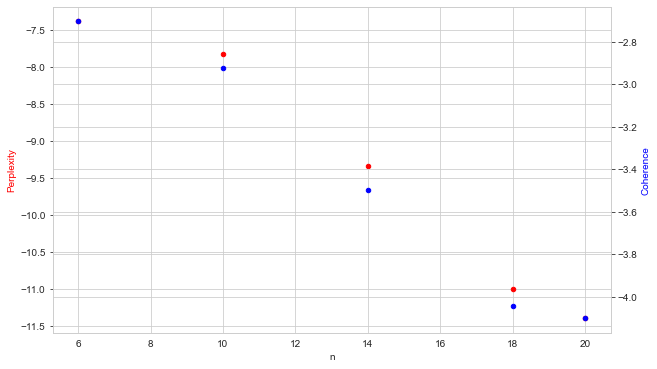

In [83]:
# plot coherence and perplexity
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()

df_gs.loc[default_filter].plot.scatter(x="n", y=["perplexity"], ax=ax1, color="red")
df_gs.loc[default_filter].plot.scatter(x="n", y=["coherence"], ax=ax2, color="blue")

ax1.set_ylabel("Perplexity", color="red")
ax2.set_ylabel("Coherence", color="blue")

plt.show()


In [128]:
df_gs.sort_values("coherence", ascending=False).head(5)

,n,alpha,beta,perplexity,coherence
71,6,0.3,0.5,-7.326465,-2.702304
12,6,symmetric,auto,-7.384624,-2.705840
3,6,0.5,0.7,-7.363319,-2.723083
52,6,0.7,0.3,-7.312336,-2.749567
78,6,symmetric,0.7,-7.362559,-2.762945


In [129]:
df_gs.sort_values("perplexity", ascending=False).head(5)

,n,alpha,beta,perplexity,coherence
10,6,0.5,0.3,-7.291577,-2.833887
65,6,0.3,0.3,-7.300302,-2.878438
52,6,0.7,0.3,-7.312336,-2.749567
40,6,0.7,auto,-7.315862,-2.904131
75,6,0.5,auto,-7.319669,-2.875691


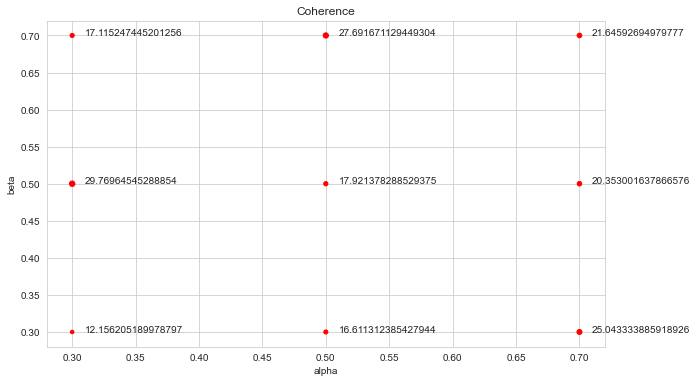

In [121]:
# plot alpha on the x axis, and beta on the y axis, with the size of the bubble determined by the coherence score, and the value annotated in the bubble
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

fig, ax1 = plt.subplots(figsize=(10, 6))

df_gs_float = df_gs.loc[default_filter_neg & (df_gs.n == 6)].copy()
df_gs_float.alpha = df_gs_float.alpha.astype(float)
df_gs_float.beta = df_gs_float.beta.astype(float)
df_gs_float.coherence = (df_gs_float.coherence +3)*100

df_gs_float.plot.scatter(x="alpha", y="beta", s=df_gs_float.coherence, ax=ax1, color="red")

for i, row in df_gs_float.iterrows():
    ax1.annotate(row["coherence"], (row["alpha"]+0.01, row["beta"]))
plt.title("Coherence")
plt.show()



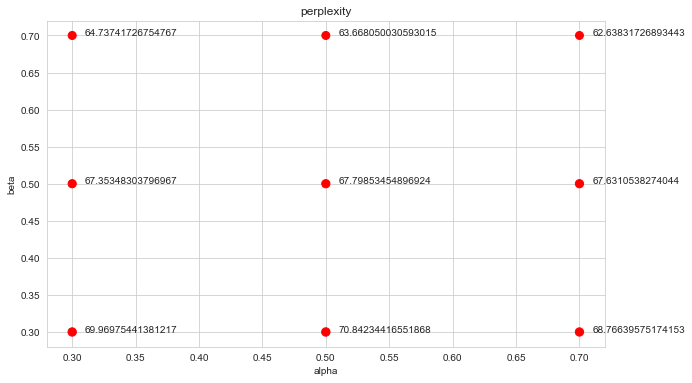

In [127]:
# plot alpha on the x axis, and beta on the y axis, with the size of the bubble determined by the coherence score, and the value annotated in the bubble
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

fig, ax1 = plt.subplots(figsize=(10, 6))

df_gs_float = df_gs.loc[default_filter_neg & (df_gs.n == 6)].copy()
df_gs_float.alpha = df_gs_float.alpha.astype(float)
df_gs_float.beta = df_gs_float.beta.astype(float)
df_gs_float.perplexity = (df_gs_float.perplexity +8)*100

df_gs_float.plot.scatter(x="alpha", y="beta", s=df_gs_float.perplexity, ax=ax1, color="red")

for i, row in df_gs_float.iterrows():
    ax1.annotate(row["perplexity"], (row["alpha"]+0.01, row["beta"]))
plt.title("perplexity")
plt.show()


# 6. Best Model

In [130]:
df_gs.sort_values("coherence", ascending=False).iloc[0]

n                    6
alpha              0.3
beta               0.5
perplexity   -7.326465
coherence    -2.702304
Name: 71, dtype: object

In [131]:
# Treinando Modelo de melhor resultado
n = 6
alpha = 0.3
beta = 0.5

lda_model, results = train_and_eval(n, alpha, beta)

print("Results:\n", results)

Results:
 {'n': 6, 'alpha': 0.3, 'beta': 0.5, 'perplexity': -7.350026435458468, 'coherence': -2.951591751354842}


In [161]:
# Visualizando tópicos
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
import matplotlib.pyplot as plt


In [162]:
print("LDA visualization")
lda_visualization = gensimvis.prepare(lda_model, gensim_corpus, gensim_dictionary)
pyLDAvis.display(lda_visualization)

LDA visualization


c:\Users\Bruno\miniconda3\envs\pln\lib\site-packages\pyLDAvis\_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


In [138]:
def print_topics_formatted(model, num_words=10):
    topics = model.print_topics(num_words=num_words)
    for i, topic in enumerate(topics):
        t_str = topic[1]
        t_str = re.sub(r"[^a-zA-Z]", " ", t_str)
        t_str = re.sub(r"\s+", " ", t_str)
        t_str = f"Tópico {i}: {t_str}"
        print(t_str)

def print_topics(model, num_words=10):
    topics = model.print_topics(num_words=num_words)
    for topic in topics:
        print(topic)

In [142]:
# Imprimindo tópicos encontrados
print("LDA topics")
print_topics_formatted(lda_model, num_words=20)

LDA topics
Tópico 0:  excelent bom boa atendimento hotel otima servico estrutura comida localizacao praia tudo qualidad princip acomodaco instalaco legal atencao infraestrutura local 
Tópico 1:  lugar otimo maravilhoso atendimento excelent equip maravilhosa nota todo recomendo familia paraben restaurant tudo super tia comida tio top show 
Tópico 2:  piscina nao quarto sao hotel restaurant praia crianca cafe comida manha pouco resort ponto muita area opco boa bem tambem 
Tópico 3:  melhor perfeito incrivel hotel experiencia espetacular amei tudo vista linda copacabana resort rio porto demai simplesment paraiso luxo brasil sonho 
Tópico 4:  bem funcionario lindo cafe manha hotel quarto atencioso super limpo educado sao agradavel ambient bonito aconchegant sensacion todo local prestativo 
Tópico 5:  nao hotel dia todo voce ate pra tudo hosped pessoa recepcao funcionario sempr ano vez aqui outro lugar ficar fazer 


In [147]:
lda_topics_chat_gpt = {
0:"Qualidade e conforto em hotel com ótimo atendimento",
1:"Excelente atendimento e diversão em família no resort",
2:"Opções de lazer e variedade de serviços em hotel com piscina",
3:"Experiência incrível em hotel de luxo com vistas deslumbrantes",
4:"Aconchego, limpeza e atendimento atencioso em hotel acolhedor",
5:"Flexibilidade e tranquilidade para uma estadia perfeita em qualquer lugar",
}

In [140]:
# Imprimindo tópicos encontrados
print("HDP topics")
print_topics_formatted(hdp_model)

HDP topics
Tópico 0:  nao hotel quarto bem bom piscina atendimento sao excelent cafe
Tópico 1:  bom hotel atendimento excelent nao quarto lugar otimo bem boa
Tópico 2:  hotel bom atendimento excelent nao lugar quarto otimo bem boa
Tópico 3:  bom hotel excelent atendimento nao lugar quarto otimo bem boa
Tópico 4:  bom excelent atendimento hotel lugar otimo nao quarto bem boa
Tópico 5:  bom excelent atendimento hotel lugar otimo nao quarto bem boa
Tópico 6:  bom excelent atendimento hotel lugar otimo nao quarto bem boa
Tópico 7:  bom excelent atendimento hotel lugar otimo nao quarto bem boa
Tópico 8:  bom excelent atendimento hotel lugar otimo nao quarto boa bem
Tópico 9:  bom excelent atendimento hotel lugar otimo nao quarto bem boa
Tópico 10:  bom excelent atendimento hotel lugar otimo nao quarto boa bem
Tópico 11:  bom excelent atendimento hotel lugar otimo nao quarto bem boa
Tópico 12:  bom excelent atendimento hotel lugar otimo nao quarto boa bem
Tópico 13:  bom excelent atendimento

In [182]:
# Definindo função para atribuir topicos ao documento
def get_topics(tokens, model=lda_model, topic_names:dict = {}, prefix="lda_"):
    doc_bow = gensim_dictionary.doc2bow(tokens)
    doc_topics_list = model[doc_bow]
    doc_topics = {str(topic_id):topic_prob for topic_id, topic_prob in doc_topics_list}
    doc_topics["first_topic"] = sorted(doc_topics_list, key=lambda x:x[1], reverse=1)[0][0]
    doc_topics["first_topic_name"] = topic_names.get(doc_topics["first_topic"], None)
    result = pd.Series(doc_topics)
    result = result.add_prefix(prefix)
    return result

get_topics(text_tokens_flat.iloc[2], model=lda_model, topic_names=lda_topics_chat_gpt)

lda_0                                                             0.20768
lda_1                                                            0.015508
lda_2                                                            0.471985
lda_3                                                            0.014579
lda_4                                                            0.014935
lda_5                                                            0.275312
lda_first_topic                                                         2
lda_first_topic_name    Opções de lazer e variedade de serviços em hot...
dtype: object

In [187]:
# df_prep.loc[(~df_prep["text_na"]),["lda_0","lda_1","lda_2","lda_3","lda_4","lda_5","lda_first_topic","lda_first_topic_name"]] = \
text_topics = \
    df_prep.loc[(~df_prep["text_na"]),["text_tokens_flat"]].progress_apply(
        lambda x: get_topics(x.text_tokens_flat, model=lda_model, topic_names=lda_topics_chat_gpt),
        axis=1,
        result_type="expand",
    ).fillna(0)

100%|██████████| 150774/150774 [02:08<00:00, 1173.29it/s]


In [188]:
df_prep.loc[(~df_prep["text_na"]),["lda_0","lda_1","lda_2","lda_3","lda_4","lda_5","lda_first_topic","lda_first_topic_name"]] = \
    text_topics

In [193]:
df_prep.loc[(~df_prep["text_na"]),["lda_0","lda_1","lda_2","lda_3","lda_4","lda_5","lda_first_topic","lda_first_topic_name"]].head()

,lda_0,lda_1,lda_2,lda_3,lda_4,lda_5,lda_first_topic,lda_first_topic_name
0,0.185793,0.010707,0.710173,0.010427,0.071751,0.011150,2.0,Opções de lazer e variedade de serviços em hot...
1,0.000000,0.094988,0.280340,0.000000,0.000000,0.598752,5.0,Flexibilidade e tranquilidade para uma estadia...
2,0.207678,0.015509,0.471994,0.014579,0.014935,0.275304,2.0,Opções de lazer e variedade de serviços em hot...
3,0.170221,0.011083,0.279901,0.114263,0.010541,0.413991,5.0,Flexibilidade e tranquilidade para uma estadia...
6,0.167963,0.014956,0.185602,0.016846,0.015106,0.599528,5.0,Flexibilidade e tranquilidade para uma estadia...


In [194]:
save_df(df_prep, "data/processed", "df_topics")

data/processed/df_topics_2023-07-09_23-48-54_286392.pq
